In [1]:
import json

from interpml import config, utils
from interpml import info_architecture as ia
from interpml import plotting

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pprint import pprint

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Building infoarchs for optimization task

In [2]:
# Defined by lists of (row1, col1, height, width) tuples
height, width = 12, 12
specs = []

#---------- 2-component dashboards ----------#
split = 8
specs.append([
    (0, 0, height, split),
    (0, split, height, width - split)
])

split = 4
specs.append([
    (0, 0, height, split),
    (0, split, height, width - split)
])

split = 6
specs.append([
    (0, 0, split, width),
    (split, 0, height - split, width)
])

split = 8
specs.append([
    (0, 0, split, width),
    (split, 0, height - split, width)
])

#---------- 3-component dashboards ----------#
split = 6, 6
specs.append([
    (0, 0, height, split[0]),
    (0, split[0], split[1], width - split[0]),
    (split[1], split[0], height - split[1], width - split[0])
])

split = 5, 6
specs.append([
    (0, 0, height, split[0]),
    (0, split[0], split[1], width - split[0]),
    (split[1], split[0], height - split[1], width - split[0])
])

split = 6, 4
specs.append([
    (0, 0, split[0], split[1]),
    (split[0], 0, height - split[0], split[1]),
    (0, split[1], height, width - split[1])
])

split = 4, 6
specs.append([
    (0, 0, split[0], split[1]),
    (split[0], 0, height - split[0], split[1]),
    (0, split[1], height, width - split[1])
])

split = 4, 6
specs.append([
    (0, 0, split[0], split[1]),
    (0, split[1], split[0], width - split[1]),
    (split[0], 0, height - split[0], width)
])

split = 6, 4
specs.append([
    (0, 0, split[0], split[1]),
    (0, split[1], split[0], width - split[1]),
    (split[0], 0, height - split[0], width)
])

split = 4, 6
specs.append([
    (0, 0, split[0], width),
    (split[0], 0, height - split[0], split[1]),
    (split[0], split[1], height - split[0], width - split[1])
])

split = 6, 4
specs.append([
    (0, 0, split[0], width),
    (split[0], 0, height - split[0], split[1]),
    (split[0], split[1], height - split[0], width - split[1])
])

#---------- 4 component dashboards ----------#

split = 6, 7, 5
specs.append([
    (0, 0, split[0], split[1]),
    (0, split[1], split[0], width - split[1]),
    (split[0], 0, height - split[0], split[2]),
    (split[0], split[2], height - split[0], width - split[2])
])

split = 6, 6, 6
specs.append([
    (0, 0, split[0], split[1]),
    (0, split[1], split[0], width - split[1]),
    (split[0], 0, height - split[0], split[2]),
    (split[0], split[2], height - split[0], width - split[2])
])

split = 8, 4, 8
specs.append([
    (0, 0, height, split[0]),
    (0, split[0], split[1], width - split[0]),
    (split[1], split[0], split[2] - split[1], width - split[0]),
    (split[2], split[0], height - split[2], width - split[0])
])

split = 8, 4, 8
specs.append([
    (0, 0, split[0], split[1]),
    (0, split[1], split[0], split[2] - split[1]),
    (0, split[2], split[0], width - split[2]),
    (split[0], 0, height - split[0], width)
])

split = 6, 4, 8
specs.append([
    (0, 0, split[0], width),
    (split[0], 0, height - split[0], split[1]),
    (split[0], split[1], height - split[0], split[2] - split[1]),
    (split[0], split[2], height - split[0], width - split[2])
])

split = 4, 6, 8
specs.append([
    (0, 0, height, split[0]),
    (0, split[0], split[1], width - split[0]),
    (split[1], split[0], height - split[1], split[2]),
    (split[1], split[2], height - split[1], width - split[2])
])

In [3]:
id2vis = {
    1: 'confusion-matrix',
    2: 'feature-importance-bubble',
    3: 'feature-importance-pie',
    4: 'feature-importance-tree',
    5: 'parallel-coordinates',
    6: 'class-vote'
}
vis2id = {c: i for i, c in id2vis.items()}

In [4]:
# Defining the logic
# Aspect ratio is defined as width / height
min_aspect_ratios = {
    'confusion-matrix': 1 / 2
}
max_aspect_ratios = {
    'confusion-matrix': 2
}

def compute_aspect_ratio(arr, idx):
    idxwhere = np.argwhere(arr == idx)
    r0, c0 = idxwhere.min(axis=0)
    r1, c1 = idxwhere.max(axis=0)
    h = r1 - r0
    w = c1 - c0
    return w / h

def ia_is_acceptable(new_ia):
    vis_ids = np.unique(new_ia)
    vis_names = [id2vis[i] for i in vis_ids]

    # Checking feature importance vis's
    n_feat_impt = len([n for n in vis_names if 'feature-importance' in n])
    if n_feat_impt > 1:
        return False
    
    # Check aspect ratio
    for vis_id, name in zip(vis_ids, vis_names):
        asp_true = compute_aspect_ratio(new_ia, vis_id)
        asp_min = min_aspect_ratios.get(name, None)
        if asp_min:
            if asp_true < asp_min:
                return False
        asp_max = max_aspect_ratios.get(name, None)
        if asp_max:
            if asp_true > asp_max:
                return False
    
    return True

In [7]:
treemaps = []
info_archs = []
n_per_ia = 10
for i, arch in enumerate(specs):
    new_treemaps = []
    j = 0
    while len(new_treemaps) < n_per_ia and j < 50:
        j += 1
        arr = ia.spec2arr(arch, n_components=len(id2vis), height=height, width=width)
        if not ia_is_acceptable(arr):
            continue
        is_copy = False
        for arr_past in new_treemaps:
            if (arr == arr_past).all():
                is_copy = True
                break
        if is_copy:
            continue
        new_treemaps.append(arr)
        try:
            new_ia = ia.InfoArchTree.from_array(i * 100 + j, arr, height=height, width=width)
            info_archs.append(new_ia)
        except:
            pass
    treemaps.extend(new_treemaps)

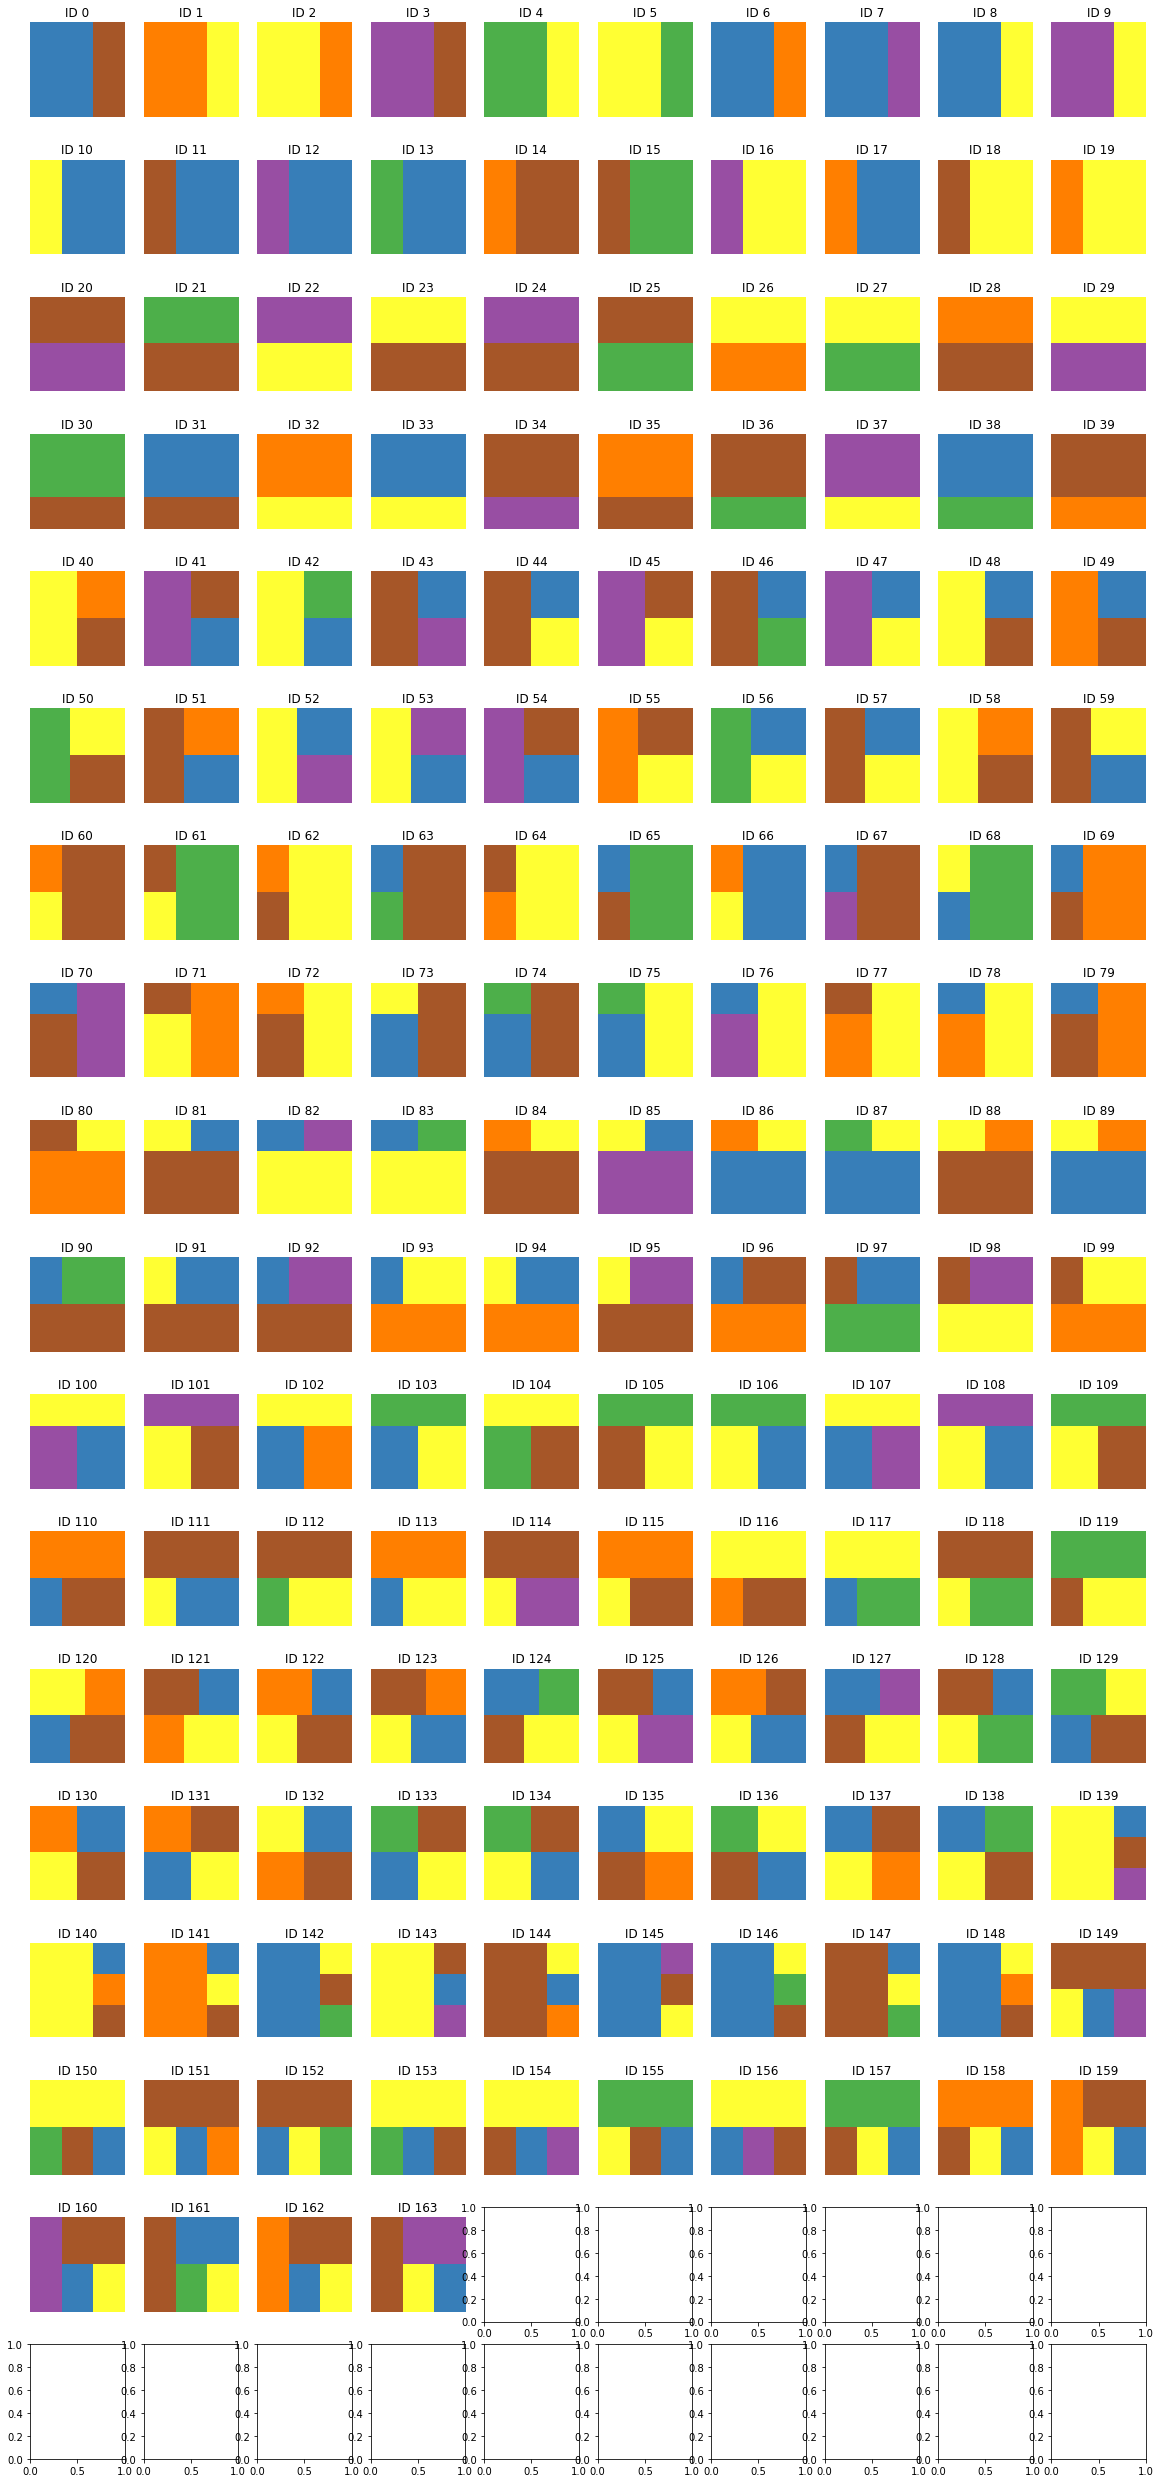

In [8]:
fig, axs = plt.subplots(len(specs), n_per_ia, figsize=(n_per_ia * 2, len(specs) * 2.5))
for i, (treemap, ax) in enumerate(zip(treemaps, axs.flat)):
    plotting.plot_treemap(treemap, ax=ax, vmin=0, vmax=9, cmap='Set1')
    ax.set_title(f'ID {i}')
    ax.axis('off')

In [15]:
# Computing pairwise distances
n_components = len(id2vis)

def get_features(info_archs, n_components):
    """Get the feature vectors for the trees associated with the JSON-like
    objects in `info_arch_jsons`

    :param info_arch_jsons: JSON-like dicts with the InfoArchTree specs
    :param n_components: int
    :return: 'feat_vecs'
    """
    feat_vecs = []
    for ia_tree in info_archs:
        feat_vec = ia_tree.get_feature_vector(components=n_components)
        feat_vecs.append(feat_vec)
    return np.stack(feat_vecs, axis=0)

feats = get_features(info_archs, n_components)

In [36]:
diffs = ((np.expand_dims(feats, 0) - np.expand_dims(feats, 1)) ** 2).sum(axis=-1)
mean_diffs = diffs.mean(axis=1)
idxs_min = np.argsort(mean_diffs)[:10]
for idx in idxs_min:
    print(idx, mean_diffs[idx])

162 39.1616982836495
57 40.07669941282746
159 40.10478771454381
160 40.273063459801264
131 40.66185354561879
44 40.77961269196025
130 40.863581187895214
59 41.25877935862692
48 41.585041214995485
133 41.66210761065944


In [37]:
# Defining the start dashboard as 162: the one with the lowest mean distance to the others
idx_start = idxs_min[0]
start_db = info_archs[idx_start].to_json()


{'id': 1743,
 'height': 12,
 'width': 12,
 'components': {'id': -1,
  'height': 1,
  'width': 1.0,
  'orientation': 'v',
  'left_child': {'id': 4.0,
   'height': 1,
   'width': 0.3333333333333333,
   'orientation': 'v',
   'left_child': {},
   'right_child': {}},
  'right_child': {'id': -1,
   'height': 1,
   'width': 0.6666666666666667,
   'orientation': 'v',
   'left_child': {'id': 6.0,
    'height': 0.5,
    'width': 1,
    'orientation': 'h',
    'left_child': {},
    'right_child': {}},
   'right_child': {'id': -1,
    'height': 0.5,
    'width': 1,
    'orientation': 'h',
    'left_child': {'id': 1.0,
     'height': 1,
     'width': 0.5,
     'orientation': 'v',
     'left_child': {},
     'right_child': {}},
    'right_child': {'id': -1,
     'height': 1,
     'width': 0.5,
     'orientation': 'v',
     'left_child': {'id': 5.0,
      'height': 1,
      'width': 1.0,
      'orientation': 'v',
      'left_child': {},
      'right_child': {}},
     'right_child': {}}}}}}

In [9]:
res = {'architectures': [a.to_json() for a in info_archs]}

In [10]:
pprint(res)

{'architectures': [{'components': {'height': 1,
                                   'id': -1,
                                   'left_child': {'height': 1,
                                                  'id': 1.0,
                                                  'left_child': {},
                                                  'orientation': 'v',
                                                  'right_child': {},
                                                  'width': 0.6666666666666666},
                                   'orientation': 'v',
                                   'right_child': {'height': 1,
                                                   'id': -1,
                                                   'left_child': {'height': 1,
                                                                  'id': 6.0,
                                                                  'left_child': {},
                                                                  'orientati

                                                                  'width': 1},
                                                   'orientation': 'h',
                                                   'right_child': {},
                                                   'width': 1},
                                   'width': 1.0},
                    'height': 12,
                    'id': 230,
                    'width': 12},
                   {'components': {'height': 1,
                                   'id': -1,
                                   'left_child': {'height': 0.5,
                                                  'id': 6.0,
                                                  'left_child': {},
                                                  'orientation': 'h',
                                                  'right_child': {},
                                                  'width': 1},
                                   'orientation': 'v',
                       

                                   'width': 1.0},
                    'height': 12,
                    'id': 424,
                    'width': 12},
                   {'components': {'height': 1,
                                   'id': -1,
                                   'left_child': {'height': 1,
                                                  'id': 3.0,
                                                  'left_child': {},
                                                  'orientation': 'v',
                                                  'right_child': {},
                                                  'width': 0.5},
                                   'orientation': 'v',
                                   'right_child': {'height': 1,
                                                   'id': -1,
                                                   'left_child': {'height': 0.5,
                                                                  'id': 6.0,
                        

                                                   'orientation': 'v',
                                                   'right_child': {},
                                                   'width': 0.6666666666666667},
                                   'width': 1.0},
                    'height': 12,
                    'id': 606,
                    'width': 12},
                   {'components': {'height': 1,
                                   'id': -1,
                                   'left_child': {'height': 1,
                                                  'id': -1,
                                                  'left_child': {'height': 0.5,
                                                                 'id': 4.0,
                                                                 'left_child': {},
                                                                 'orientation': 'h',
                                                                 'right_child': {},
     

                                                                                 'orientation': 'h',
                                                                                 'right_child': {},
                                                                                 'width': 1},
                                                                  'orientation': 'h',
                                                                  'right_child': {},
                                                                  'width': 1},
                                                  'width': 0.5},
                                   'orientation': 'v',
                                   'right_child': {'height': 1,
                                                   'id': 5.0,
                                                   'left_child': {},
                                                   'orientation': 'v',
                                                   'right_child': {},

                                                                 'id': 5.0,
                                                                 'left_child': {},
                                                                 'orientation': 'v',
                                                                 'right_child': {},
                                                                 'width': 0.3333333333333333},
                                                  'orientation': 'h',
                                                  'right_child': {'height': 1,
                                                                  'id': -1,
                                                                  'left_child': {'height': 1,
                                                                                 'id': 3.0,
                                                                                 'left_child': {},
                                                                   

                    'id': 1101,
                    'width': 12},
                   {'components': {'height': 1,
                                   'id': -1,
                                   'left_child': {'height': 0.5,
                                                  'id': 6.0,
                                                  'left_child': {},
                                                  'orientation': 'h',
                                                  'right_child': {},
                                                  'width': 1},
                                   'orientation': 'v',
                                   'right_child': {'height': 0.5,
                                                   'id': -1,
                                                   'left_child': {'height': 1,
                                                                  'id': 5.0,
                                                                  'left_child': {},
                       

                                                  'right_child': {'height': 1,
                                                                  'id': -1,
                                                                  'left_child': {'height': 1,
                                                                                 'id': 2.0,
                                                                                 'left_child': {},
                                                                                 'orientation': 'v',
                                                                                 'right_child': {},
                                                                                 'width': 1.0},
                                                                  'orientation': 'v',
                                                                  'right_child': {},
                                                                  'width': 0.416666666666666

                                                   'width': 0.5},
                                   'width': 1.0},
                    'height': 12,
                    'id': 1337,
                    'width': 12},
                   {'components': {'height': 1,
                                   'id': -1,
                                   'left_child': {'height': 1,
                                                  'id': -1,
                                                  'left_child': {'height': 0.5,
                                                                 'id': 1.0,
                                                                 'left_child': {},
                                                                 'orientation': 'h',
                                                                 'right_child': {},
                                                                 'width': 1},
                                                  'orientation': 'v',
            

                                                                   'id': -1,
                                                                   'left_child': {'height': 1,
                                                                                  'id': 1.0,
                                                                                  'left_child': {},
                                                                                  'orientation': 'v',
                                                                                  'right_child': {},
                                                                                  'width': 0.5},
                                                                   'orientation': 'v',
                                                                   'right_child': {'height': 1,
                                                                                   'id': -1,
                                                           

                                                                  'width': 1},
                                                   'orientation': 'v',
                                                   'right_child': {'height': 0.5,
                                                                   'id': -1,
                                                                   'left_child': {'height': 1,
                                                                                  'id': 2.0,
                                                                                  'left_child': {},
                                                                                  'orientation': 'v',
                                                                                  'right_child': {},
                                                                                  'width': 0.5},
                                                                   'orientation': 'h',
                

In [63]:
with (config.data / 'ia_layouts.json').open('w') as f:
    json.dump(res, f)